In [6]:
!pip install pandas numpy scikit-learn matplotlib seaborn


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
device_ids = ['EVM001','EVM002','EVM003','EVM004','EVM005']
timestamps = pd.date_range(start='2025-10-03 10:00', periods=100, freq='min')  # fixed 'T' → 'min'

data = []
for ts in timestamps:
    for dev in device_ids:
        vote_success = np.random.choice([0,1], p=[0.05,0.95])
        latency_ms = np.random.normal(200,50)
        sim_status = np.random.choice(['active','inactive'], p=[0.95,0.05])
        anomaly_flag = 1 if (vote_success==0 or sim_status=='inactive') else 0
        data.append([dev, ts, vote_success, latency_ms, sim_status, anomaly_flag])

df = pd.DataFrame(data, columns=['device_id','timestamp','vote_success','latency_ms','sim_status','anomaly_flag'])
df['latency_ms'] = df['latency_ms'].clip(lower=50)  # latency cannot be below 50 ms

print(df.head())


  device_id           timestamp  vote_success  latency_ms sim_status  \
0    EVM001 2025-10-03 10:00:00             1  203.649838     active   
1    EVM002 2025-10-03 10:00:00             1  239.003909     active   
2    EVM003 2025-10-03 10:00:00             1  173.626534     active   
3    EVM004 2025-10-03 10:00:00             1  218.083829     active   
4    EVM005 2025-10-03 10:00:00             0  146.470283     active   

   anomaly_flag  
0             0  
1             0  
2             0  
3             0  
4             1  


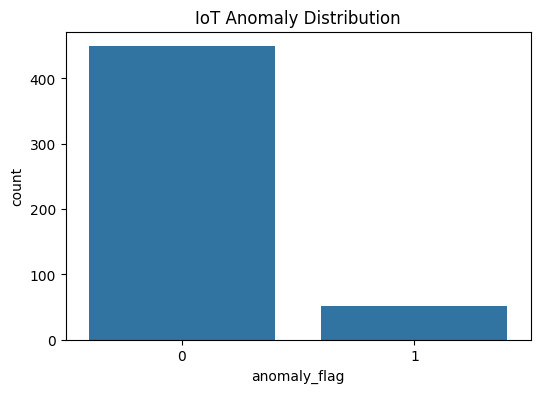

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='anomaly_flag', data=df)
plt.title("IoT Anomaly Distribution")
plt.show()


In [11]:
X = df[['vote_success','latency_ms','sim_status']]
y = df['anomaly_flag']

# One-hot encoding
X = pd.get_dummies(X, columns=['sim_status'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00        14

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



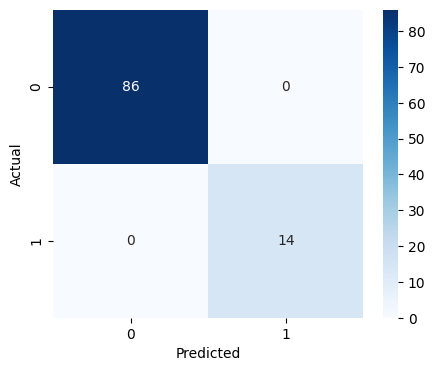

In [12]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [13]:
text_logs = [
    "Vote recorded successfully",
    "Sim inactive, vote failed",
    "Firmware mismatch detected",
    "Vote blocked due to network error",
    "Sim tampered, alert raised",
    "Vote success, latency normal"
]
labels = [0,1,1,1,1,0]

vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(text_logs)

nlp_model = MultinomialNB()
nlp_model.fit(X_text, labels)

# Test
test_logs = ["Sim inactive, vote blocked", "Vote recorded successfully"]
X_test_text = vectorizer.transform(test_logs)
nlp_pred = nlp_model.predict(X_test_text)

for log, pred in zip(test_logs, nlp_pred):
    print(f"Log: '{log}' -> Anomaly: {pred}")


Log: 'Sim inactive, vote blocked' -> Anomaly: 1
Log: 'Vote recorded successfully' -> Anomaly: 0


In [14]:
df['device_status'] = np.where(df['anomaly_flag']==1, 'Check / Alert', 'Normal')
print(df[['device_id','timestamp','device_status']].head())


  device_id           timestamp  device_status
0    EVM001 2025-10-03 10:00:00         Normal
1    EVM002 2025-10-03 10:00:00         Normal
2    EVM003 2025-10-03 10:00:00         Normal
3    EVM004 2025-10-03 10:00:00         Normal
4    EVM005 2025-10-03 10:00:00  Check / Alert


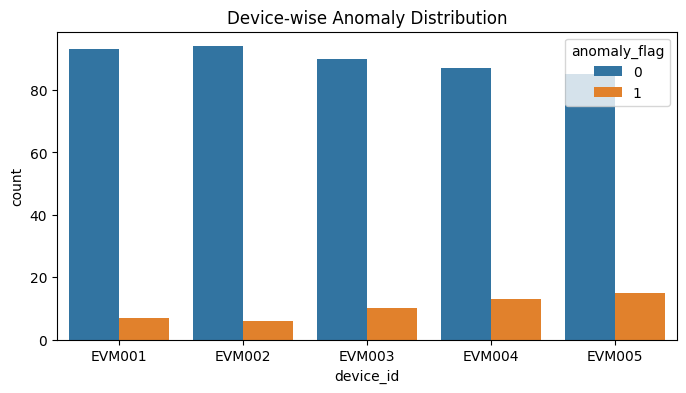

In [15]:
plt.figure(figsize=(8,4))
sns.countplot(x='device_id', hue='anomaly_flag', data=df)
plt.title("Device-wise Anomaly Distribution")
plt.show()


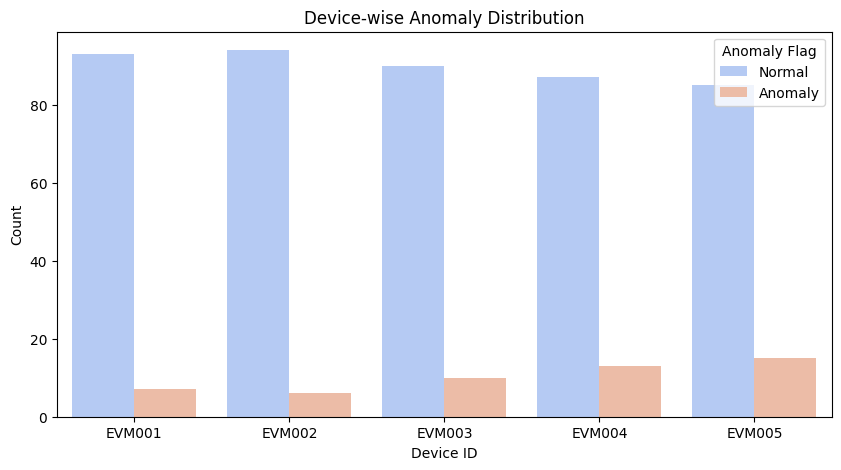

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(x='device_id', hue='anomaly_flag', data=df, palette='coolwarm')
plt.title("Device-wise Anomaly Distribution")
plt.xlabel("Device ID")
plt.ylabel("Count")
plt.legend(title="Anomaly Flag", labels=["Normal","Anomaly"])
plt.show()


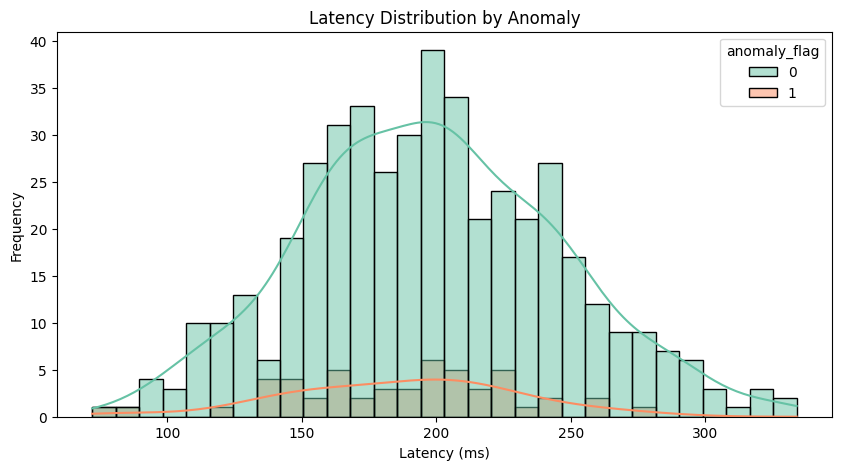

In [17]:
plt.figure(figsize=(10,5))
sns.histplot(df, x='latency_ms', hue='anomaly_flag', bins=30, kde=True, palette='Set2')
plt.title("Latency Distribution by Anomaly")
plt.xlabel("Latency (ms)")
plt.ylabel("Frequency")
plt.show()


/tmp/ipython-input-4201462365.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_time = df.groupby(df['timestamp'].dt.floor('10T'))['anomaly_flag'].sum().reset_index()


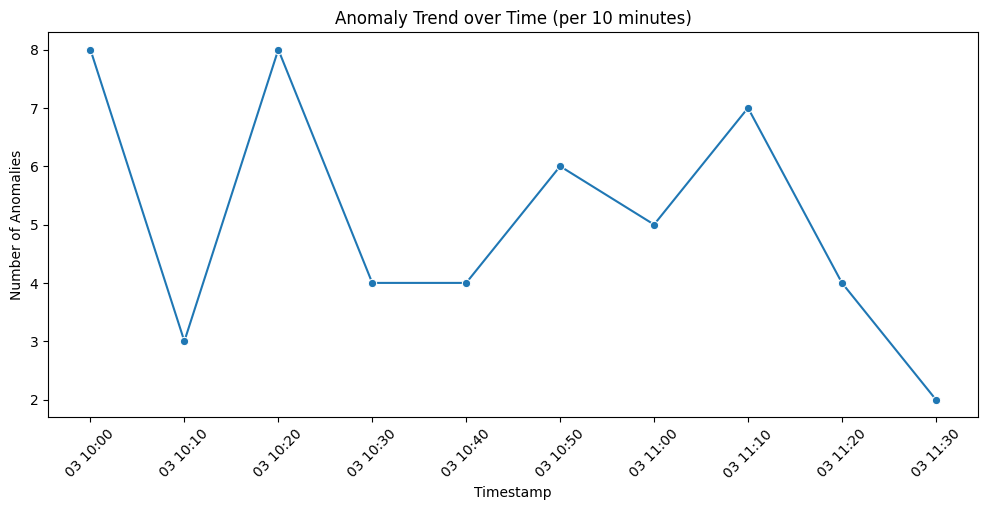

In [18]:
df_time = df.groupby(df['timestamp'].dt.floor('10T'))['anomaly_flag'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=df_time, x='timestamp', y='anomaly_flag', marker='o')
plt.title("Anomaly Trend over Time (per 10 minutes)")
plt.xlabel("Timestamp")
plt.ylabel("Number of Anomalies")
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-3891475847.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='vote_success', y='anomaly_flag', data=df, ci=None)


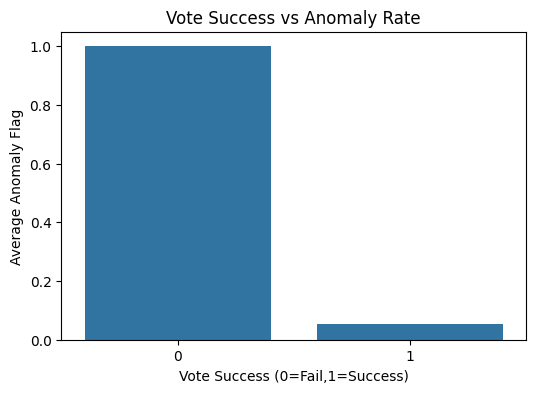

In [19]:
plt.figure(figsize=(6,4))
sns.barplot(x='vote_success', y='anomaly_flag', data=df, ci=None)
plt.title("Vote Success vs Anomaly Rate")
plt.xlabel("Vote Success (0=Fail,1=Success)")
plt.ylabel("Average Anomaly Flag")
plt.show()


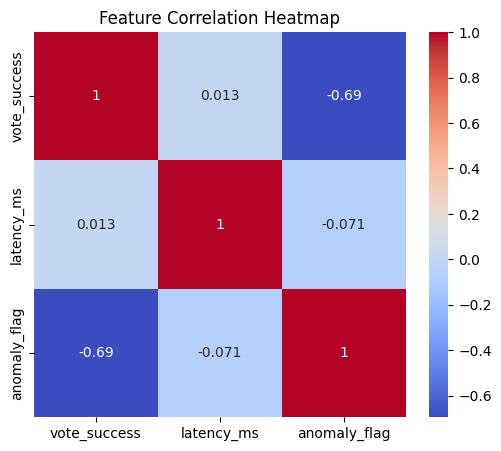

In [20]:
corr = df[['vote_success','latency_ms','anomaly_flag']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


/tmp/ipython-input-1919984947.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nlp_pred_counts.index, y=nlp_pred_counts.values, palette='magma')


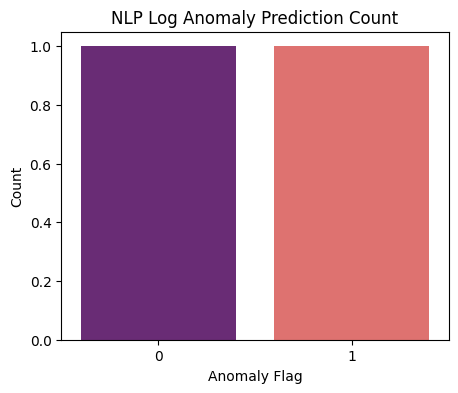

In [21]:
nlp_pred_counts = pd.Series(nlp_pred).value_counts().sort_index()
plt.figure(figsize=(5,4))
sns.barplot(x=nlp_pred_counts.index, y=nlp_pred_counts.values, palette='magma')
plt.title("NLP Log Anomaly Prediction Count")
plt.xlabel("Anomaly Flag")
plt.ylabel("Count")
plt.show()


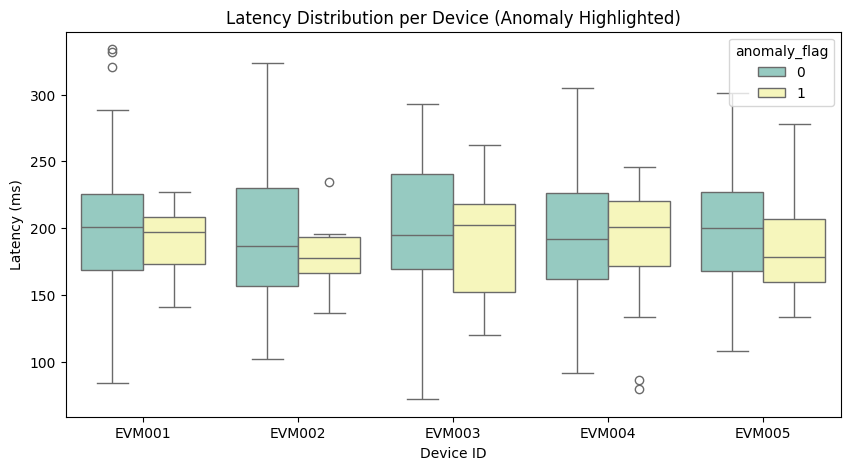

In [22]:
plt.figure(figsize=(10,5))
sns.boxplot(x='device_id', y='latency_ms', hue='anomaly_flag', data=df, palette='Set3')
plt.title("Latency Distribution per Device (Anomaly Highlighted)")
plt.xlabel("Device ID")
plt.ylabel("Latency (ms)")
plt.show()


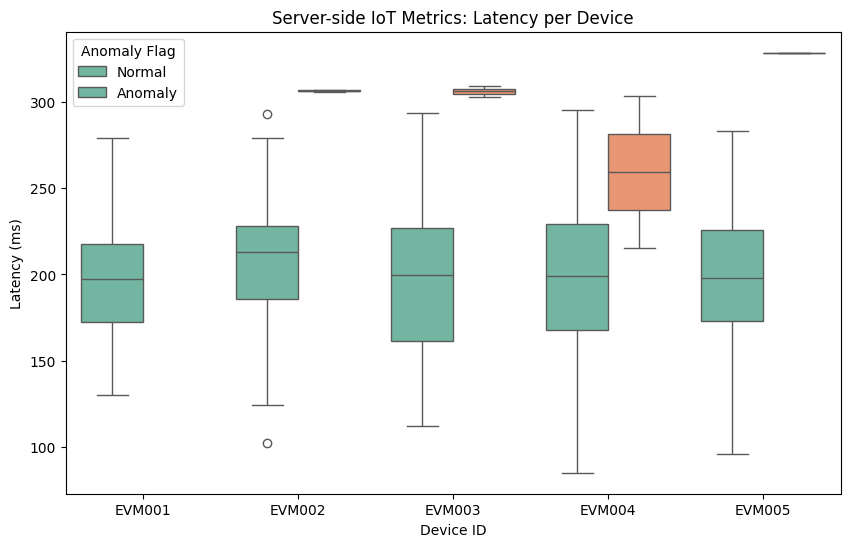

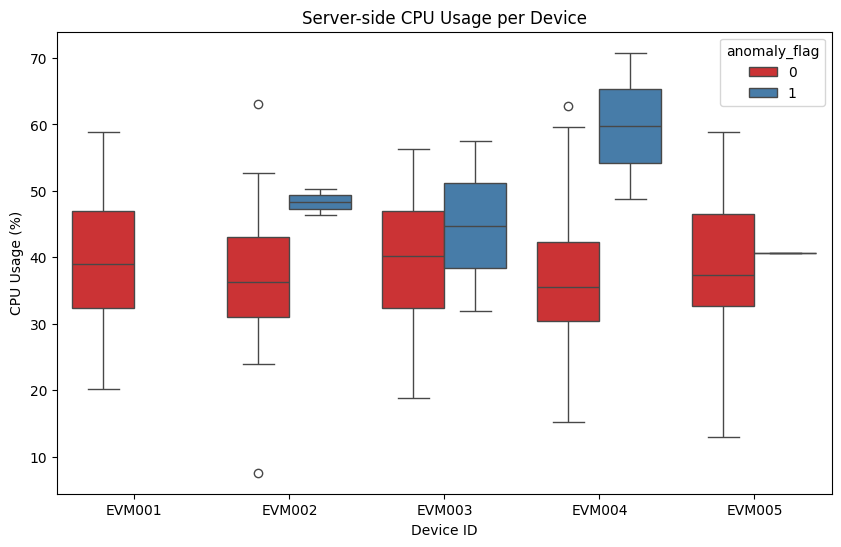

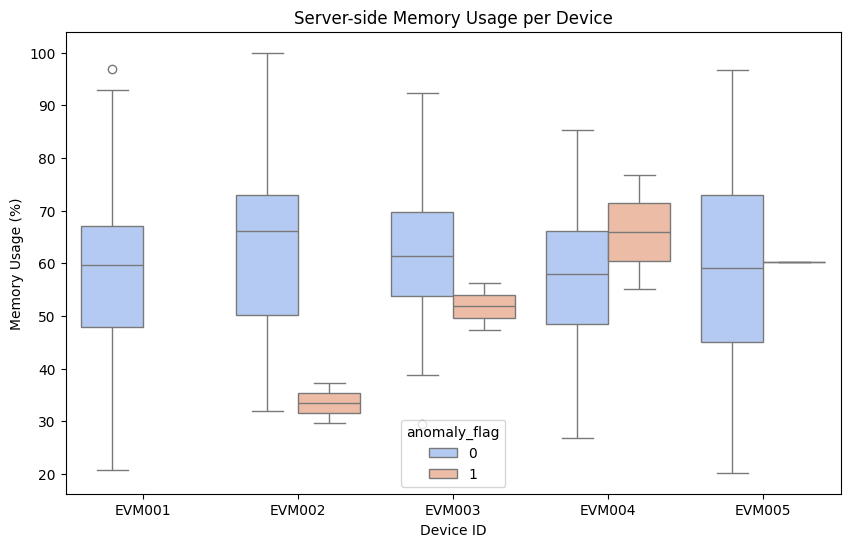

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate server-side IoT data for devices
np.random.seed(42)
device_ids = ['EVM001','EVM002','EVM003','EVM004','EVM005']
server_load = []

for dev in device_ids:
    for i in range(50):  # 50 data points per device
        latency = np.random.normal(200,50)  # ms
        cpu_usage = np.random.normal(40,10) # %
        memory_usage = np.random.normal(60,15) # %
        anomaly_flag = 1 if latency>300 or cpu_usage>70 else 0
        server_load.append([dev, latency, cpu_usage, memory_usage, anomaly_flag])

df_server = pd.DataFrame(server_load, columns=['device_id','latency_ms','cpu_usage','memory_usage','anomaly_flag'])
df_server['latency_ms'] = df_server['latency_ms'].clip(lower=50)
df_server['cpu_usage'] = df_server['cpu_usage'].clip(0,100)
df_server['memory_usage'] = df_server['memory_usage'].clip(0,100)

# Boxplot: Latency per Device
plt.figure(figsize=(10,6))
sns.boxplot(x='device_id', y='latency_ms', hue='anomaly_flag', data=df_server, palette='Set2')
plt.title("Server-side IoT Metrics: Latency per Device")
plt.xlabel("Device ID")
plt.ylabel("Latency (ms)")
plt.legend(title="Anomaly Flag", labels=["Normal","Anomaly"])
plt.show()

# Optional: CPU Usage Boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='device_id', y='cpu_usage', hue='anomaly_flag', data=df_server, palette='Set1')
plt.title("Server-side CPU Usage per Device")
plt.xlabel("Device ID")
plt.ylabel("CPU Usage (%)")
plt.show()

# Optional: Memory Usage Boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='device_id', y='memory_usage', hue='anomaly_flag', data=df_server, palette='coolwarm')
plt.title("Server-side Memory Usage per Device")
plt.xlabel("Device ID")
plt.ylabel("Memory Usage (%)")
plt.show()


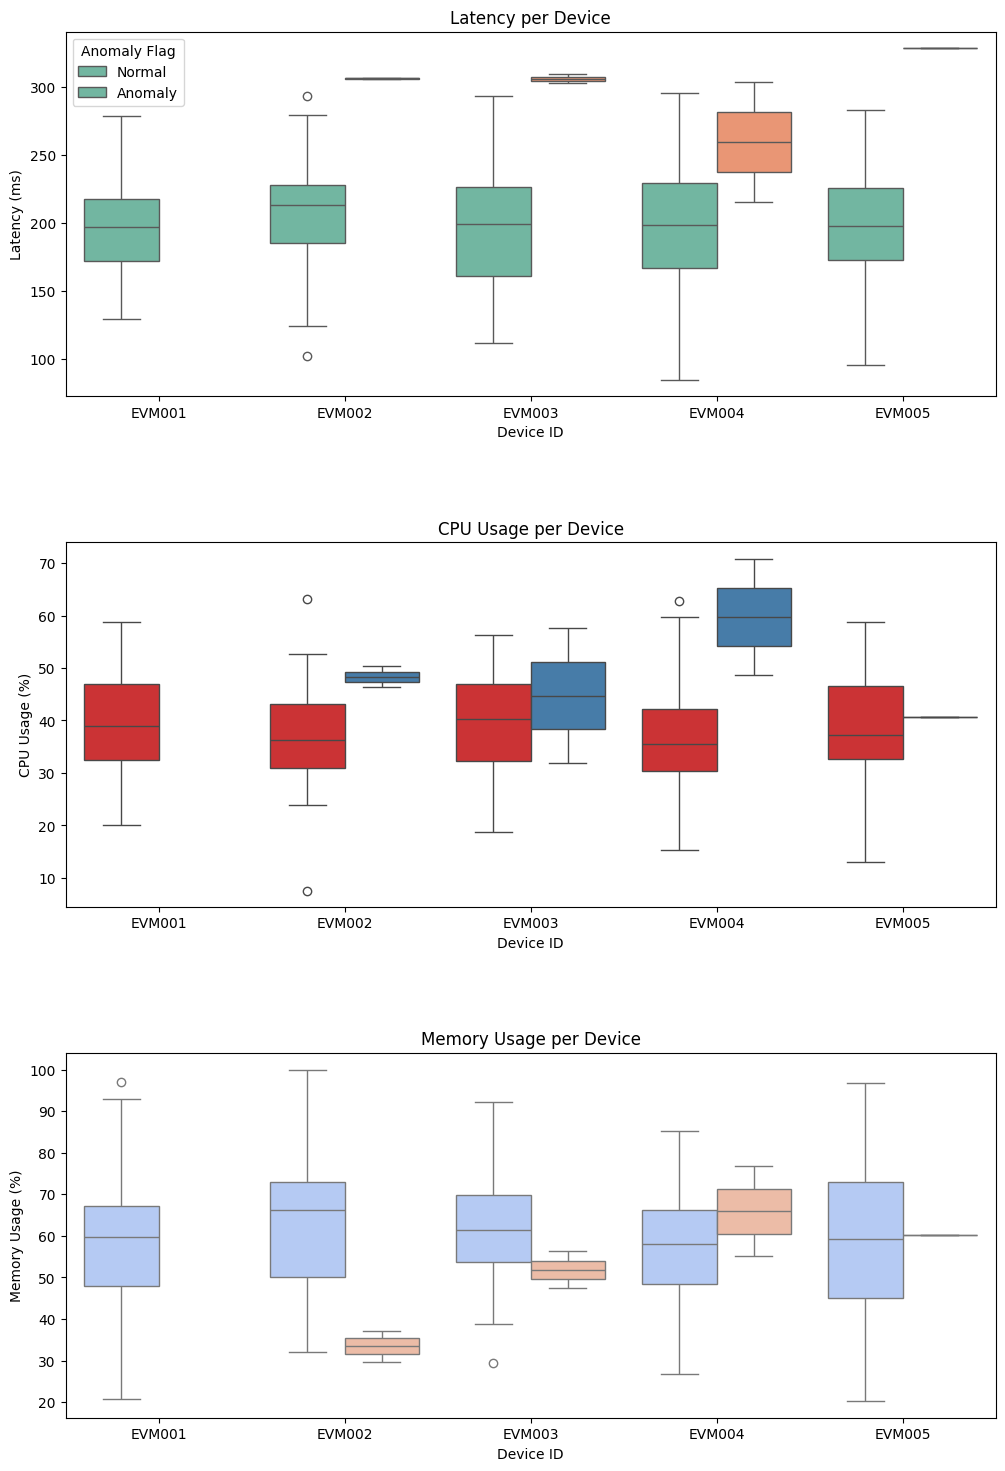

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Simulate server-side IoT data
np.random.seed(42)
device_ids = ['EVM001','EVM002','EVM003','EVM004','EVM005']
server_load = []

for dev in device_ids:
    for i in range(50):  # 50 data points per device
        latency = np.random.normal(200,50)  # ms
        cpu_usage = np.random.normal(40,10) # %
        memory_usage = np.random.normal(60,15) # %
        anomaly_flag = 1 if latency>300 or cpu_usage>70 else 0
        server_load.append([dev, latency, cpu_usage, memory_usage, anomaly_flag])

df_server = pd.DataFrame(server_load, columns=['device_id','latency_ms','cpu_usage','memory_usage','anomaly_flag'])
df_server['latency_ms'] = df_server['latency_ms'].clip(lower=50)
df_server['cpu_usage'] = df_server['cpu_usage'].clip(0,100)
df_server['memory_usage'] = df_server['memory_usage'].clip(0,100)

# 2️⃣ Combined Dashboard Figure
fig, axes = plt.subplots(3, 1, figsize=(12,18))
plt.subplots_adjust(hspace=0.4)

# Latency Boxplot
sns.boxplot(x='device_id', y='latency_ms', hue='anomaly_flag', data=df_server, palette='Set2', ax=axes[0])
axes[0].set_title("Latency per Device")
axes[0].set_xlabel("Device ID")
axes[0].set_ylabel("Latency (ms)")
axes[0].legend(title="Anomaly Flag", labels=["Normal","Anomaly"])

# CPU Usage Boxplot
sns.boxplot(x='device_id', y='cpu_usage', hue='anomaly_flag', data=df_server, palette='Set1', ax=axes[1])
axes[1].set_title("CPU Usage per Device")
axes[1].set_xlabel("Device ID")
axes[1].set_ylabel("CPU Usage (%)")
axes[1].legend_.remove()  # Remove duplicate legend

# Memory Usage Boxplot
sns.boxplot(x='device_id', y='memory_usage', hue='anomaly_flag', data=df_server, palette='coolwarm', ax=axes[2])
axes[2].set_title("Memory Usage per Device")
axes[2].set_xlabel("Device ID")
axes[2].set_ylabel("Memory Usage (%)")
axes[2].legend_.remove()

plt.show()


In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# 1️⃣ Simulate server-side IoT data with timestamps
np.random.seed(42)
device_ids = ['EVM001','EVM002','EVM003','EVM004','EVM005']
timestamps = pd.date_range(start='2025-10-03 10:00', periods=50, freq='T')

server_data = []
for ts in timestamps:
    for dev in device_ids:
        latency = np.random.normal(200,50)
        cpu = np.random.normal(40,10)
        memory = np.random.normal(60,15)
        anomaly_flag = 1 if latency>300 or cpu>70 else 0
        server_data.append([ts, dev, latency, cpu, memory, anomaly_flag])

df_server = pd.DataFrame(server_data, columns=['timestamp','device_id','latency_ms','cpu_usage','memory_usage','anomaly_flag'])
df_server['latency_ms'] = df_server['latency_ms'].clip(lower=50)
df_server['cpu_usage'] = df_server['cpu_usage'].clip(0,100)
df_server['memory_usage'] = df_server['memory_usage'].clip(0,100)

# 2️⃣ Interactive Line Plot: Latency over time per device
fig_latency = px.line(df_server, x='timestamp', y='latency_ms', color='device_id',
                      title='Latency Trend over Time (Server-side IoT)',
                      hover_data=['anomaly_flag'])
fig_latency.update_traces(mode='lines+markers')

# Highlight anomaly points
anomaly_points = df_server[df_server['anomaly_flag']==1]
fig_latency.add_trace(go.Scatter(
    x=anomaly_points['timestamp'],
    y=anomaly_points['latency_ms'],
    mode='markers',
    marker=dict(color='red', size=10, symbol='x'),
    name='Anomaly'
))

fig_latency.show()

# 3️⃣ Interactive Line Plot: CPU Usage over time per device
fig_cpu = px.line(df_server, x='timestamp', y='cpu_usage', color='device_id',
                  title='CPU Usage Trend over Time (Server-side IoT)',
                  hover_data=['anomaly_flag'])
fig_cpu.update_traces(mode='lines+markers')

# Highlight anomaly points
fig_cpu.add_trace(go.Scatter(
    x=anomaly_points['timestamp'],
    y=anomaly_points['cpu_usage'],
    mode='markers',
    marker=dict(color='red', size=10, symbol='x'),
    name='Anomaly'
))
fig_cpu.show()

# 4️⃣ Interactive Line Plot: Memory Usage over time per device
fig_mem = px.line(df_server, x='timestamp', y='memory_usage', color='device_id',
                  title='Memory Usage Trend over Time (Server-side IoT)',
                  hover_data=['anomaly_flag'])
fig_mem.update_traces(mode='lines+markers')

# Highlight anomaly points
fig_mem.add_trace(go.Scatter(
    x=anomaly_points['timestamp'],
    y=anomaly_points['memory_usage'],
    mode='markers',
    marker=dict(color='red', size=10, symbol='x'),
    name='Anomaly'
))
fig_mem.show()


/tmp/ipython-input-740744007.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(start='2025-10-03 10:00', periods=50, freq='T')


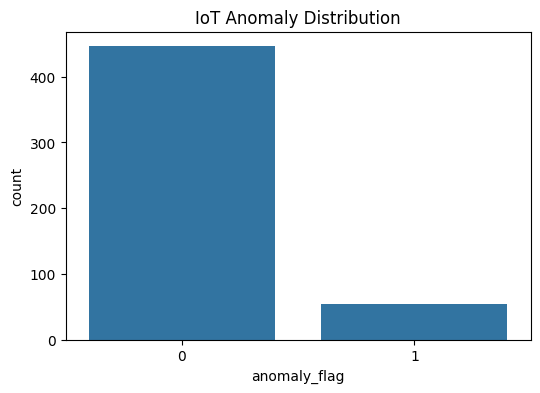

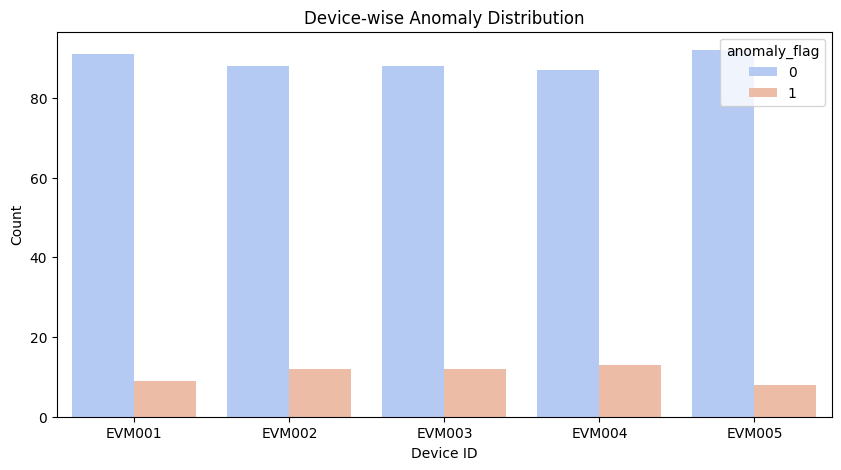

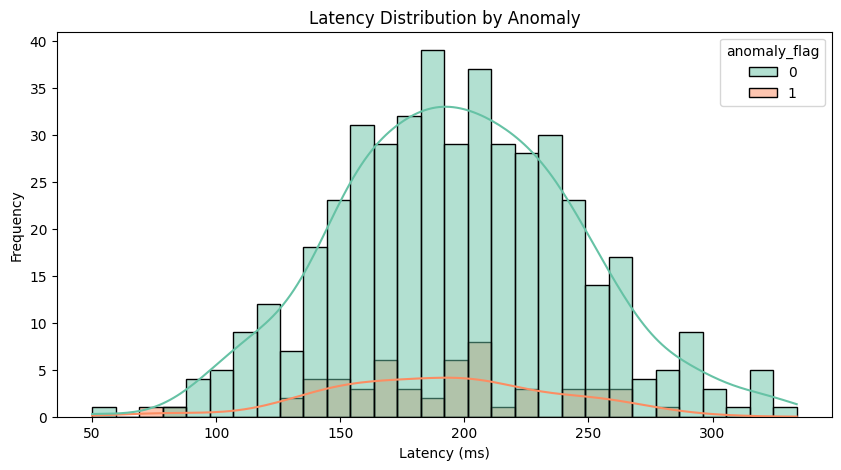

/tmp/ipython-input-781585423.py:61: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



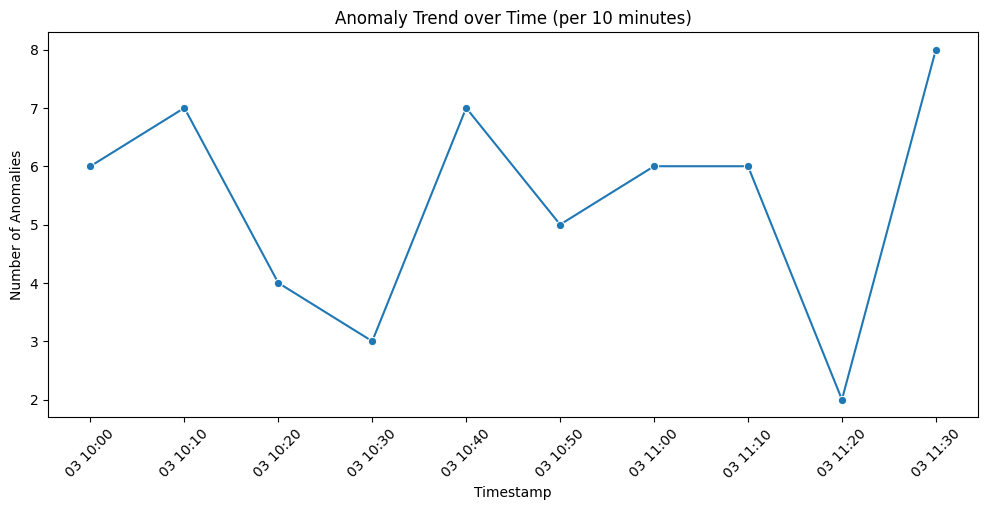

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00         9

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



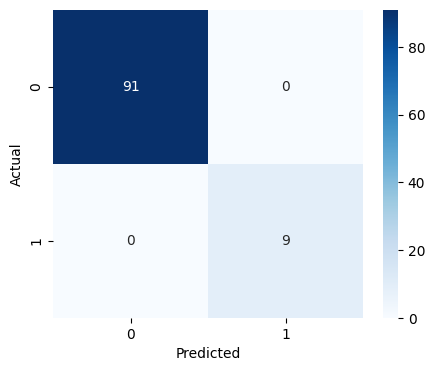

Log: 'Sim inactive, vote blocked' -> Anomaly: 1
Log: 'Vote recorded successfully' -> Anomaly: 0


/tmp/ipython-input-781585423.py:127: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



In [4]:
# -*- coding: utf-8 -*-
"""IoT Anomaly Detection and Visualization"""

# ✅ Install required packages
!pip install pandas numpy scikit-learn matplotlib seaborn plotly

# ✅ Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import plotly.express as px
import plotly.graph_objects as go

# ==========================
# 1️⃣ Simulate IoT Device Data
# ==========================
device_ids = ['EVM001','EVM002','EVM003','EVM004','EVM005']
timestamps = pd.date_range(start='2025-10-03 10:00', periods=100, freq='min')

data = []
for ts in timestamps:
    for dev in device_ids:
        vote_success = np.random.choice([0,1], p=[0.05,0.95])
        latency_ms = np.random.normal(200,50)
        sim_status = np.random.choice(['active','inactive'], p=[0.95,0.05])
        anomaly_flag = 1 if (vote_success==0 or sim_status=='inactive') else 0
        data.append([dev, ts, vote_success, latency_ms, sim_status, anomaly_flag])

df = pd.DataFrame(data, columns=['device_id','timestamp','vote_success','latency_ms','sim_status','anomaly_flag'])
df['latency_ms'] = df['latency_ms'].clip(lower=50)

# ==========================
# 2️⃣ Visualize IoT Anomalies
# ==========================
plt.figure(figsize=(6,4))
sns.countplot(x='anomaly_flag', data=df)
plt.title("IoT Anomaly Distribution")
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(x='device_id', hue='anomaly_flag', data=df, palette='coolwarm')
plt.title("Device-wise Anomaly Distribution")
plt.xlabel("Device ID")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df, x='latency_ms', hue='anomaly_flag', bins=30, kde=True, palette='Set2')
plt.title("Latency Distribution by Anomaly")
plt.xlabel("Latency (ms)")
plt.ylabel("Frequency")
plt.show()

df_time = df.groupby(df['timestamp'].dt.floor('10T'))['anomaly_flag'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=df_time, x='timestamp', y='anomaly_flag', marker='o')
plt.title("Anomaly Trend over Time (per 10 minutes)")
plt.xlabel("Timestamp")
plt.ylabel("Number of Anomalies")
plt.xticks(rotation=45)
plt.show()

# ==========================
# 3️⃣ Random Forest Model
# ==========================
X = pd.get_dummies(df[['vote_success','latency_ms','sim_status']], drop_first=True)
y = df['anomaly_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==========================
# 4️⃣ NLP for Text Logs
# ==========================
text_logs = [
    "Vote recorded successfully",
    "Sim inactive, vote failed",
    "Firmware mismatch detected",
    "Vote blocked due to network error",
    "Sim tampered, alert raised",
    "Vote success, latency normal"
]
labels = [0,1,1,1,1,0]

vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(text_logs)

nlp_model = MultinomialNB()
nlp_model.fit(X_text, labels)

test_logs = ["Sim inactive, vote blocked", "Vote recorded successfully"]
X_test_text = vectorizer.transform(test_logs)
nlp_pred = nlp_model.predict(X_test_text)

for log, pred in zip(test_logs, nlp_pred):
    print(f"Log: '{log}' -> Anomaly: {pred}")

df['device_status'] = np.where(df['anomaly_flag']==1, 'Check / Alert', 'Normal')

# ==========================
# 5️⃣ Server-side IoT Metrics Simulation
# ==========================
np.random.seed(42)
server_data = []
timestamps_server = pd.date_range(start='2025-10-03 10:00', periods=50, freq='T')

for ts in timestamps_server:
    for dev in device_ids:
        latency = np.random.normal(200,50)
        cpu = np.random.normal(40,10)
        memory = np.random.normal(60,15)
        anomaly_flag = 1 if latency>300 or cpu>70 else 0
        server_data.append([ts, dev, latency, cpu, memory, anomaly_flag])

df_server = pd.DataFrame(server_data, columns=['timestamp','device_id','latency_ms','cpu_usage','memory_usage','anomaly_flag'])
df_server['latency_ms'] = df_server['latency_ms'].clip(lower=50)
df_server['cpu_usage'] = df_server['cpu_usage'].clip(0,100)
df_server['memory_usage'] = df_server['memory_usage'].clip(0,100)

# ==========================
# 6️⃣ Interactive Plotly Visualization
# ==========================
def plot_server_metric(metric, title):
    fig = px.line(df_server, x='timestamp', y=metric, color='device_id',
                  title=title, hover_data=['anomaly_flag'])
    fig.update_traces(mode='lines+markers')
    anomalies = df_server[df_server['anomaly_flag']==1]
    fig.add_trace(go.Scatter(
        x=anomalies['timestamp'],
        y=anomalies[metric],
        mode='markers',
        marker=dict(color='red', size=10, symbol='x'),
        name='Anomaly'
    ))
    fig.show()

plot_server_metric('latency_ms', 'Latency Trend over Time (Server-side IoT)')
plot_server_metric('cpu_usage', 'CPU Usage Trend over Time (Server-side IoT)')
plot_server_metric('memory_usage', 'Memory Usage Trend over Time (Server-side IoT)')
